#### Subgroup Analysis

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import plotly.express as px
import numpy as np
import plotly.io as pio
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [32]:
# Load the dataset
file_path = 'data/AB_NYC_2019.csv'
data = pd.read_csv(file_path)
data.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Data cleaning: last-review is converted to datetime, and missing dates are filed with earliest date. Last review month is extracted for grouping and analysis. Missing values in 'reviews_per_month' is filled with 0.

In [33]:
# Convert 'last_review' to datetime
data['last_review'] = pd.to_datetime(data['last_review'], errors='coerce')
# Fill missing values in 'last_review' with the earliest date
min_date = data['last_review'].min()
data['last_review'] = data['last_review'].fillna(min_date)
# Extract month from 'last_review' to create 'review_month'
data['review_month'] = data['last_review'].dt.month

# Fill missing values in 'reviews_per_month' with 0
data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

#### Analysis 1: Popularity of Neighbourhood Segmented by Room Type
In this section, we conducted a subgroup analysis to examine the total number of reviews by neighbourhood group and room type. Review count is a metric of choice to indicate popularity of a listing. 

We began by grouping the dataset by both neighbourhood_group and room_type, and then aggregating the sum of number_of_reviews for each subgroup. This enabled us to generate a stacked bar chart, which visually represents how review volumes are distributed across different boroughs and types of accommodations. By unstacking the grouped data, we were able to isolate the contributions of each room type within a given neighbourhood group and plot them in a stacked format for comparative analysis.    

<Figure size 1200x600 with 0 Axes>

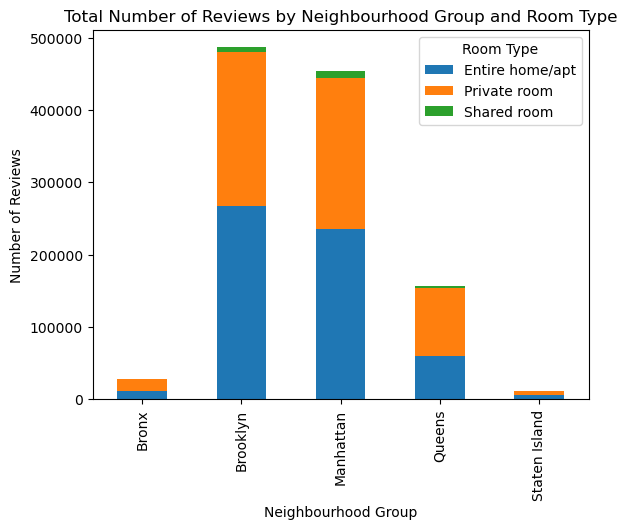

In [34]:
# Stacked Bar Chart: Total Number of Reviews by Neighbourhood Group and Room Type
room_type_reviews = data.groupby(['neighbourhood_group', 'room_type'])['number_of_reviews'].sum().unstack()
plt.figure(figsize=(12, 6))
room_type_reviews.plot(kind='bar', stacked=True)
plt.title('Total Number of Reviews by Neighbourhood Group and Room Type')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.legend(title='Room Type')
plt.show()

From the visualization, we observe that Manhattan and Brooklyn stand out as the most active boroughs in terms of Airbnb engagement, as evidenced by their significantly higher total review counts. Notably, the majority of reviews within these boroughs pertain to entire homes or apartments, suggesting a strong preference or supply of such listings. Conversely, private rooms account for a larger proportion of reviews in boroughs such as Queens and the Bronx, indicating possible differences in guest demographics or pricing structures. Shared rooms and hotel rooms consistently appear as marginal categories across all neighbourhoods. 

#### Analysis 2: Popularity of Neighbourhood Segmented by Price Range
In this analysis, we investigate the distribution of total Airbnb reviews across neighbourhood groups, segmented by defined price ranges. To achieve this, we first categorized listings into price brackets using the pd.cut function, creating seven intervals: 0–50, 51–100, 101–150, 151–200, 201–300, 301–500, and 501–1000. We then aggregated the total number of reviews within each neighbourhood_group and price_range combination, and visualized the results as a stacked bar chart.

/var/folders/sz/8qmyth415gq44nzg8jv3kkk00000gn/T/ipykernel_36486/1717920389.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Figure size 1200x600 with 0 Axes>

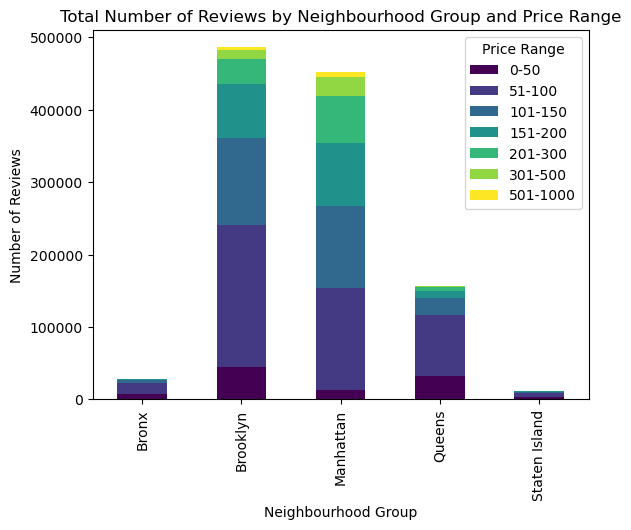

In [35]:
# Define price ranges
bins = [0, 50, 100, 150, 200, 300, 500, 1000]
labels = ['0-50', '51-100', '101-150', '151-200', '201-300', '301-500', '501-1000']
data['price_range'] = pd.cut(data['price'], bins=bins, labels=labels, right=False)

# Stacked Bar Chart: Total Number of Reviews by Neighbourhood Group and Price Range
price_range_reviews = data.groupby(['neighbourhood_group', 'price_range'])['number_of_reviews'].sum().unstack()
plt.figure(figsize=(12, 6))
price_range_reviews.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Total Number of Reviews by Neighbourhood Group and Price Range')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.legend(title='Price Range')
plt.show()

We observe that Brooklyn and Manhattan once again lead in total review counts. In both boroughs, the majority of reviews are concentrated in the mid-range price categories, particularly 51–100 and 101–150 USD. Manhattan, however, shows relatively stronger representation in higher-end segments (201–300 and above), consistent with its status as a premium destination. Queens and the Bronx have more modest overall review counts, but they show a notable skew toward lower price categories, indicating a potentially more budget-conscious visitor base. Staten Island exhibits minimal review activity across all price ranges. 

#### Analysis 3: Popularity of Individual Neighbourhoods by Borough  

In this analysis, we focus on identifying the most reviewed individual neighbourhoods within each of New York City’s five main boroughs. To do this, we first grouped the data by neighbourhood_group and neighbourhood, summing the total number of reviews for each pair. Then, for each neighbourhood group, we selected only the top three neighbourhoods with the highest total reviews. The resulting subset was reshaped for visualization and plotted as a stacked bar chart, where each bar represents a borough and is segmented by its top-performing neighbourhoods.

<Figure size 1200x600 with 0 Axes>

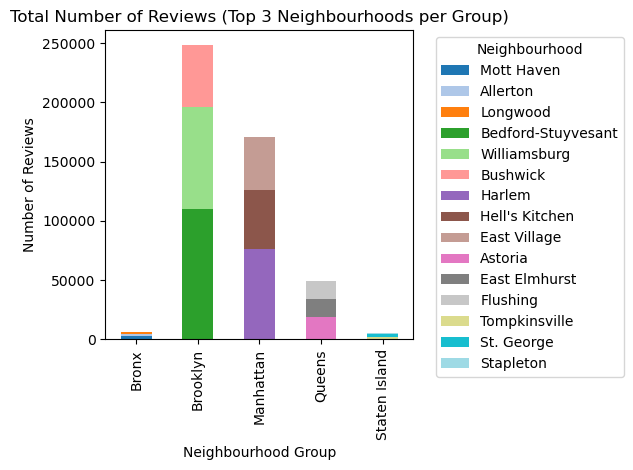

In [36]:
grouped = data.groupby(['neighbourhood_group', 'neighbourhood'])['number_of_reviews'].sum()

# For each neighbourhood group, keep only the top 3 neighbourhoods
top3 = grouped.groupby(level=0, group_keys=False).nlargest(3)
top3_unstacked = top3.unstack(fill_value=0)

plt.figure(figsize=(12, 6))
top3_unstacked.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Total Number of Reviews (Top 3 Neighbourhoods per Group)')
plt.xlabel('Neighbourhood Group')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=90)
plt.legend(title='Neighbourhood', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The chart reveals significant variation in review concentration within each borough. In Brooklyn and Manhattan, a small number of neighbourhoods dominate the review volume, with Bedford-Stuyvesant and Williamsburg in Brooklyn, and Harlem and the East Village in Manhattan, contributing substantially to their respective borough totals. These patterns suggest that guest activity is highly concentrated in specific, popular locales within otherwise large and diverse boroughs. In contrast, the Bronx, Queens, and Staten Island show a more modest scale of engagement, though even within these, particular neighbourhoods such as Mott Haven (Bronx), Astoria (Queens), and St. George (Staten Island) emerge as local hubs of Airbnb activity. 

#### Analysis 4: Monthly Distribution of Airbnb Reviews Segmented by Neighbourhood  
In this section, we analyze the monthly distribution of Airbnb reviews across New York City’s five neighbourhood groups for the year 2019. To generate this visualization, we first grouped the data by review_month and neighbourhood_group, summing the number_of_reviews within each subgroup. We then created a stacked bar chart to illustrate the volume of reviews received each month, disaggregated by borough. 

<Figure size 1400x800 with 0 Axes>

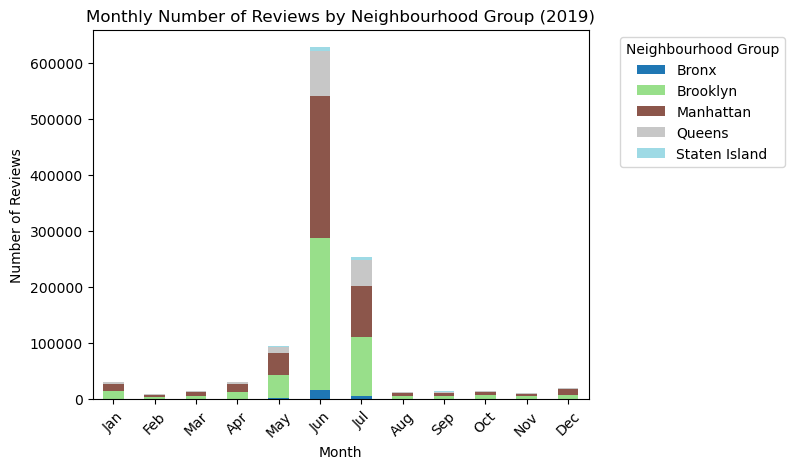

In [37]:
monthly_reviews = data.groupby(['review_month', 'neighbourhood_group'], observed=False)['number_of_reviews'].sum().unstack()

# Plot stacked bar chart
plt.figure(figsize=(14, 8))
monthly_reviews.plot(kind='bar', stacked=True, colormap='tab20')
plt.title('Monthly Number of Reviews by Neighbourhood Group (2019)')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(title='Neighbourhood Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

The resulting plot reveals a pronounced seasonal trend, with a dramatic spike in reviews during the summer months—particularly in June and July. Brooklyn and Manhattan dominate this peak period, accounting for the majority of reviews during these months, suggesting that these boroughs are key drivers of the city’s short-term rental market during high tourism season. In contrast, review activity is minimal throughout the rest of the year across all neighbourhood groups, including traditionally quieter areas such as Staten Island and the Bronx. The concentrated volume in the middle of the year likely reflects both increased travel demand and host responsiveness during peak tourism months. 

#### Analysis 5: Identifying Spatial Patterns in Airbnb Listings Using K-Means Clustering

We employed K-means clustering to identify spatial groupings—or "hotspots"—of Airbnb listings across New York City. We began by extracting the latitude and longitude coordinates of all listings with valid geolocation data.     

To determine an appropriate number of clusters, we applied the Elbow Method: K-means models were trained for values of k ranging from 1 to 10, and we plotted the corresponding inertia values (a measure of within-cluster dispersion).

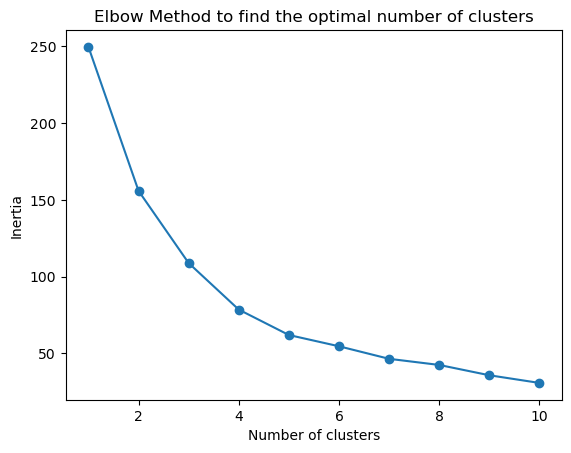

In [38]:
coords = data[['latitude', 'longitude']].dropna().values
inertias = []
K = range(1, 11)
for k in K:
    model = KMeans(n_clusters=k, random_state=42).fit(coords)
    inertias.append(model.inertia_)

plt.plot(K, inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to find the optimal number of clusters')
plt.show()


The plot revealed a clear inflection point around k = 4, suggesting that four clusters may offer a balanced trade-off between model complexity and explanatory power.

Based on this insight, we trained a K-means model with four clusters and assigned each listing a corresponding cluster label. To visualize the resulting spatial segmentation, we created an interactive map using Plotly's scatter_mapbox. 

In [39]:

kmeans = KMeans(n_clusters=4, random_state=0).fit(coords)
data['cluster'] = kmeans.labels_

fig = px.scatter_map(data, lat='latitude', lon='longitude', color='cluster',
                        title='Hotspots of Listings',
                        labels={'cluster': 'Cluster'},
                        map_style='carto-positron',
                        zoom=10, height=600)
fig.update_layout(mapbox=dict(center=dict(lat=data['latitude'].mean(), lon=data['longitude'].mean())))
fig.show()

Each listing is colored by its assigned cluster, and the map is centered over the city with a consistent zoom level for clarity. The resulting visualization reveals distinct spatial concentrations of listings—such as dense clusters in Manhattan, Brooklyn, and parts of Queens—highlighting the areas where Airbnb activity is most intense. 